In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from torch.utils.data import DataLoader, random_split
from torchmetrics import Accuracy
import matplotlib.pyplot as plt
import math

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

dataset_size = len(dataset)
train_size = int(0.75 * dataset_size)
val_size = dataset_size - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

cuda
Files already downloaded and verified
Files already downloaded and verified


Files already downloaded and verified


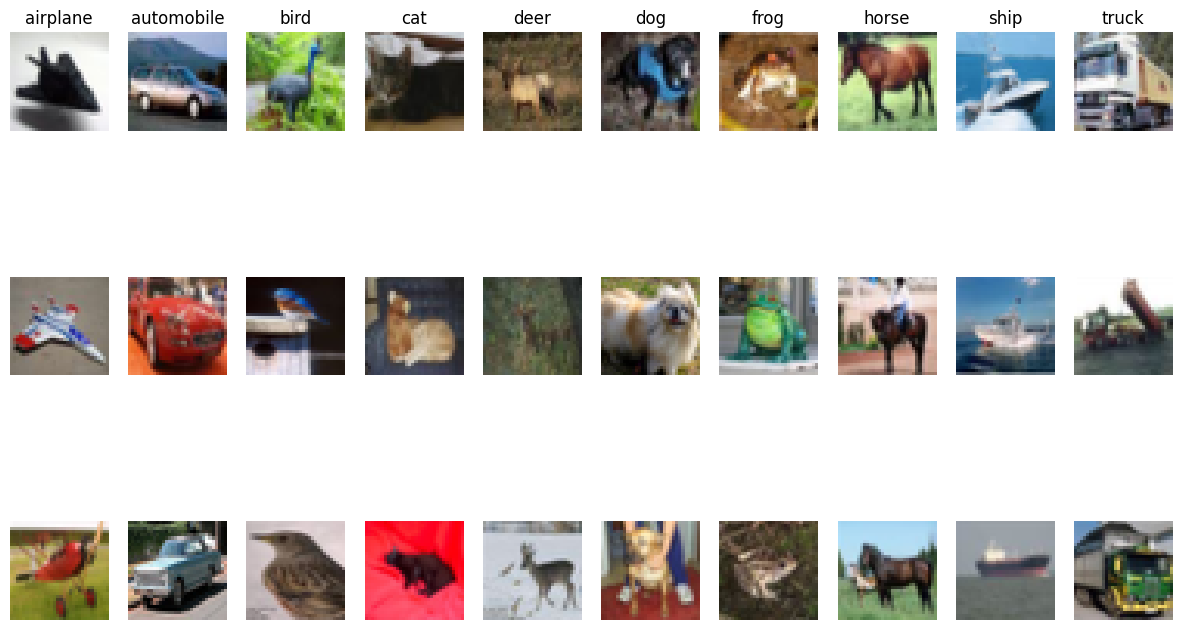

In [3]:
def show_multiple_images_per_class(dataset, classes, num_images=3):
    class_images = {i: [] for i in range(len(classes))}

    for img, label in dataset:
        if len(class_images[label]) < num_images:
            class_images[label].append(img)
        if all(len(class_images[i]) >= num_images for i in range(len(classes))):
            break

    fig, axes = plt.subplots(num_images, len(classes), figsize=(15, 3*num_images))
    for i, (label, imgs) in enumerate(class_images.items()):
        for j, img in enumerate(imgs):
            img = img.numpy().transpose((1, 2, 0))
            axes[j, i].imshow(img)
            if j == 0:
                axes[j, i].set_title(classes[label])
            axes[j, i].axis('off')

    plt.show()

show_img_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
classes = show_img_dataset.classes
show_multiple_images_per_class(show_img_dataset, classes, num_images=3)

In [4]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        # x = self.pool(F.relu(self.conv2(x)))
        # x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [5]:
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        self.model = models.resnet50()
        self.model.fc = nn.Linear(self.model.fc.in_features, 10)

    def forward(self, x):
        return self.model(x)

In [3]:
class ViT(nn.Module):
    def __init__(self):
        super(ViT, self).__init__()
        self.model = models.vit_l_32()
        self.model.heads = nn.Linear(self.model.hidden_dim, 10)

    def forward(self, x):
        x = F.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)
        return self.model(x)

In [7]:
class DenseBlock(nn.Module):
    def __init__(self, in_channels, growth_rate, num_layers):
        super(DenseBlock, self).__init__()
        self.layers = nn.ModuleList([
            self._make_layer(in_channels + i * growth_rate, growth_rate) for i in range(num_layers)
        ])

    def _make_layer(self, in_channels, growth_rate):
        return nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels, growth_rate, kernel_size=3, padding=1, bias=False),
        )

    def forward(self, x):
        for layer in self.layers:
            out = layer(x)
            x = torch.cat([x, out], dim=1)
        return x

class TransitionLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TransitionLayer, self).__init__()
        self.layer = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.AvgPool2d(kernel_size=2, stride=2),
        )

    def forward(self, x):
        return self.layer(x)

class DenseNet(nn.Module):
    def __init__(self, growth_rate=12, num_layers_per_block=4, num_classes=10):
        super(DenseNet, self).__init__()
        num_blocks = 3
        init_channels = 2 * growth_rate

        self.init_conv = nn.Conv2d(3, init_channels, kernel_size=3, padding=1, bias=False)

        channels = init_channels
        self.blocks = nn.ModuleList()
        for i in range(num_blocks):
            self.blocks.append(DenseBlock(channels, growth_rate, num_layers_per_block))
            channels += growth_rate * num_layers_per_block
            if i != num_blocks - 1:
                self.blocks.append(TransitionLayer(channels, channels // 2))
                channels = channels // 2

        self.bn = nn.BatchNorm2d(channels)
        self.fc = nn.Linear(channels, num_classes)

    def forward(self, x):
        x = self.init_conv(x)
        for block in self.blocks:
            x = block(x)
        x = torch.mean(x, dim=[2, 3])  # Global average pooling
        x = self.fc(x)
        return x

In [8]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_ratio=4.0, dropout=0.1):
        super(TransformerEncoderBlock, self).__init__()
        self.attention = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, int(embed_dim * mlp_ratio)),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(int(embed_dim * mlp_ratio), embed_dim),
            nn.Dropout(dropout),
        )
        self.norm2 = nn.LayerNorm(embed_dim)

    def forward(self, x):
        # Multi-head self-attention
        attn_output, _ = self.attention(x, x, x)
        x = self.norm1(x + attn_output)
        # Feed-forward network
        mlp_output = self.mlp(x)
        x = self.norm2(x + mlp_output)
        return x

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.block(x)

class ConvolutionalTransformer(nn.Module):
    def __init__(self, img_size=32, in_channels=3, num_classes=10, embed_dim=64, num_heads=4, num_layers=6):
        super(ConvolutionalTransformer, self).__init__()

        self.conv1 = ConvBlock(in_channels, embed_dim)
        self.conv2 = ConvBlock(embed_dim, embed_dim)

        self.flatten = nn.Flatten(2)
        self.positional_encoding = nn.Parameter(torch.randn(1, img_size * img_size, embed_dim))

        self.encoder = nn.Sequential(
            *[
                TransformerEncoderBlock(embed_dim, num_heads, mlp_ratio=4.0, dropout=0.1)
                for _ in range(num_layers)
            ]
        )
        self.layer_norm = nn.LayerNorm(embed_dim)
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.flatten(2).transpose(1, 2) + self.positional_encoding
        x = self.encoder(x)
        x = self.layer_norm(x.mean(dim=1))
        x = self.fc(x)
        return x


In [4]:
def train_model(model, train_loader, val_loader, num_epochs=10, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.3)

    train_losses, val_accuracies = [], []
    accuracy_metric = Accuracy(task="multiclass", num_classes=10).to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        scheduler.step()
        train_losses.append(running_loss / len(train_loader))

        # Validation phase
        model.eval()
        val_accuracy = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                val_accuracy += accuracy_metric(outputs, labels).item()
        val_accuracies.append(val_accuracy / len(val_loader))

        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}, Val Accuracy: {val_accuracies[-1]:.4f}")

    return train_losses, val_accuracies


def test_model(model, test_loader):
    model.eval()
    accuracy_metric = Accuracy(task="multiclass", num_classes=10).to(device)
    test_accuracy = 0.0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            test_accuracy += accuracy_metric(outputs, labels).item()

    print(f"Test Accuracy: {test_accuracy / len(test_loader):.4f}")

def plot_metrics(train_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()

    plt.show()


Training
Epoch [1/10], Loss: 1.4666, Val Accuracy: 0.5869
Epoch [2/10], Loss: 0.9277, Val Accuracy: 0.6568
Epoch [3/10], Loss: 0.7514, Val Accuracy: 0.7140
Epoch [4/10], Loss: 0.6308, Val Accuracy: 0.7456
Epoch [5/10], Loss: 0.5353, Val Accuracy: 0.7373
Epoch [6/10], Loss: 0.4456, Val Accuracy: 0.7694
Epoch [7/10], Loss: 0.2481, Val Accuracy: 0.7908
Epoch [8/10], Loss: 0.1872, Val Accuracy: 0.7907
Epoch [9/10], Loss: 0.1401, Val Accuracy: 0.7978
Epoch [10/10], Loss: 0.1027, Val Accuracy: 0.7949


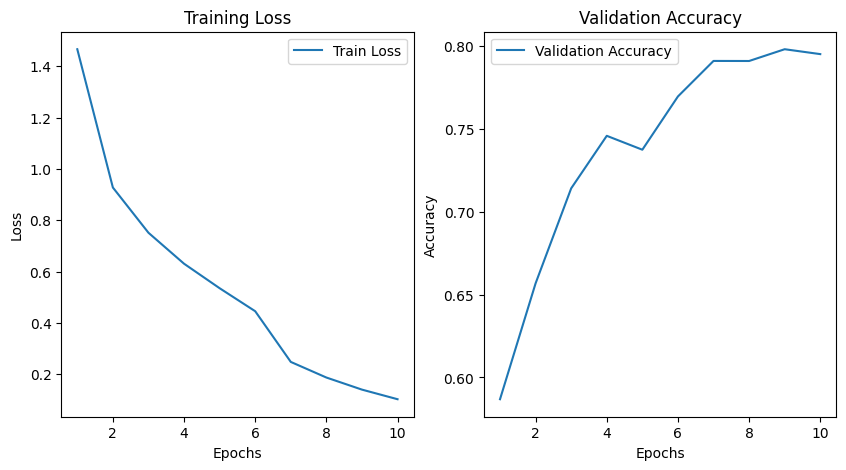


Testing
Test Accuracy: 0.7902


In [41]:
cnn_model = CNN()

print(f"\nTraining")
model = cnn_model.to(device)
train_losses, val_accuracies = train_model(model, train_loader, val_loader, num_epochs=10)
plot_metrics(train_losses, val_accuracies)
print(f"\nTesting")
test_model(model, test_loader)



Training
Epoch [1/10], Loss: 1.9931, Val Accuracy: 0.3674
Epoch [2/10], Loss: 1.6840, Val Accuracy: 0.4342
Epoch [3/10], Loss: 1.6213, Val Accuracy: 0.2588
Epoch [4/10], Loss: 1.8270, Val Accuracy: 0.3518
Epoch [5/10], Loss: 1.4942, Val Accuracy: 0.4857
Epoch [6/10], Loss: 1.3952, Val Accuracy: 0.5097
Epoch [7/10], Loss: 1.3271, Val Accuracy: 0.5238
Epoch [8/10], Loss: 1.2609, Val Accuracy: 0.5428
Epoch [9/10], Loss: 1.1627, Val Accuracy: 0.5780
Epoch [10/10], Loss: 1.1304, Val Accuracy: 0.5809


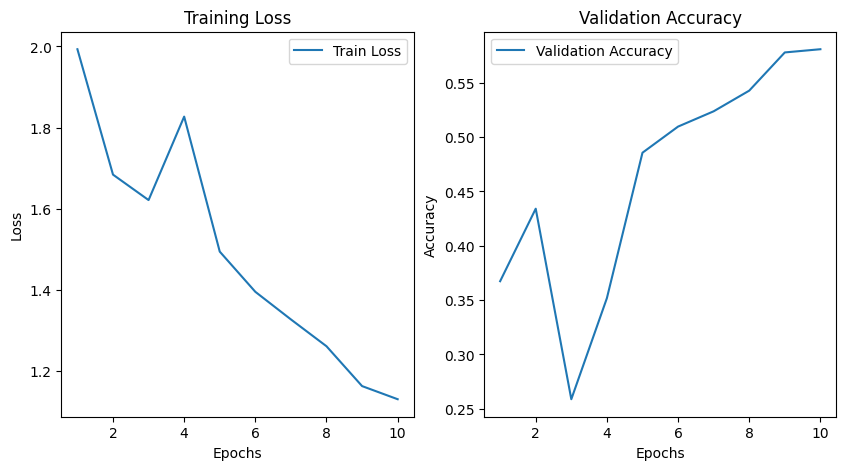


Testing
Test Accuracy: 0.5821


In [16]:
resnet_module = ResNet()

print(f"\nTraining")
model = resnet_module.to(device)
train_losses, val_accuracies = train_model(model, train_loader, val_loader, num_epochs=10)
plot_metrics(train_losses, val_accuracies)
print(f"\nTesting")
test_model(model, test_loader)


Training
Epoch [1/10], Loss: 1.5210, Val Accuracy: 0.5290
Epoch [2/10], Loss: 1.1144, Val Accuracy: 0.5611
Epoch [3/10], Loss: 0.9687, Val Accuracy: 0.5380
Epoch [4/10], Loss: 0.8799, Val Accuracy: 0.6672
Epoch [5/10], Loss: 0.8128, Val Accuracy: 0.6427
Epoch [6/10], Loss: 0.7605, Val Accuracy: 0.6713
Epoch [7/10], Loss: 0.6395, Val Accuracy: 0.7501
Epoch [8/10], Loss: 0.6066, Val Accuracy: 0.7470
Epoch [9/10], Loss: 0.5848, Val Accuracy: 0.7583
Epoch [10/10], Loss: 0.5679, Val Accuracy: 0.7525


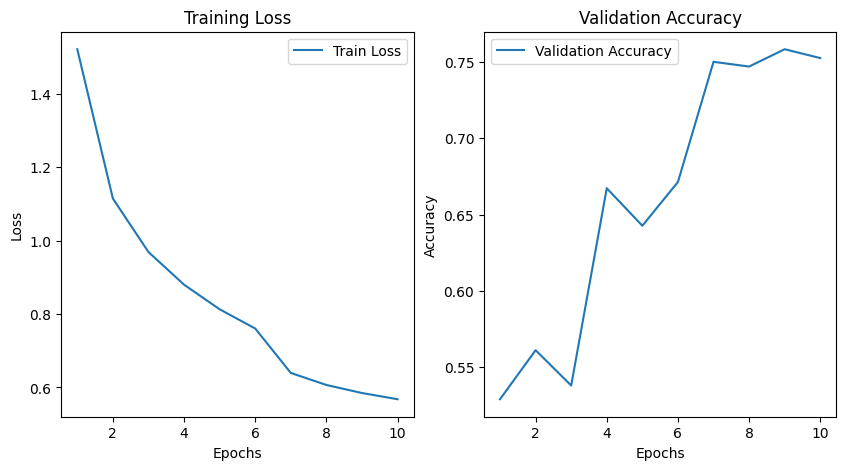


Testing
Test Accuracy: 0.7440


In [42]:
densenet_model = DenseNet()

print(f"\nTraining")
model = densenet_model.to(device)
train_losses, val_accuracies = train_model(model, train_loader, val_loader, num_epochs=10)
plot_metrics(train_losses, val_accuracies)
print(f"\nTesting")
test_model(model, test_loader)


Training
Epoch [1/10], Loss: 1.7605, Val Accuracy: 0.4381
Epoch [2/10], Loss: 1.3932, Val Accuracy: 0.5478
Epoch [3/10], Loss: 1.2052, Val Accuracy: 0.6000
Epoch [4/10], Loss: 1.0688, Val Accuracy: 0.6137
Epoch [5/10], Loss: 0.9809, Val Accuracy: 0.6399
Epoch [6/10], Loss: 0.9210, Val Accuracy: 0.6804
Epoch [7/10], Loss: 0.8562, Val Accuracy: 0.6993
Epoch [8/10], Loss: 0.7310, Val Accuracy: 0.7305
Epoch [9/10], Loss: 0.6955, Val Accuracy: 0.7302
Epoch [10/10], Loss: 0.6744, Val Accuracy: 0.7390


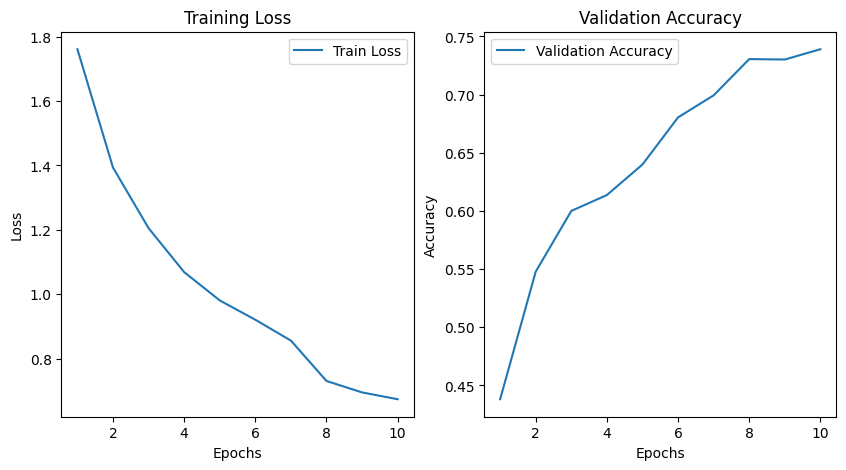


Testing
Test Accuracy: 0.7383


In [11]:
cvt_model = ConvolutionalTransformer()

print(f"\nTraining")
model = cvt_model.to(device)
train_losses, val_accuracies = train_model(model, train_loader, val_loader, num_epochs=10)
plot_metrics(train_losses, val_accuracies)
print(f"\nTesting")
test_model(model, test_loader)


Training
Epoch [1/10], Loss: 2.2263, Val Accuracy: 0.2009
Epoch [2/10], Loss: 2.0465, Val Accuracy: 0.2245
Epoch [3/10], Loss: 2.0311, Val Accuracy: 0.1994
Epoch [4/10], Loss: 2.0783, Val Accuracy: 0.2232
Epoch [5/10], Loss: 2.0679, Val Accuracy: 0.2484
Epoch [6/10], Loss: 2.0417, Val Accuracy: 0.2078
Epoch [7/10], Loss: 1.9710, Val Accuracy: 0.2520
Epoch [8/10], Loss: 1.9413, Val Accuracy: 0.2777
Epoch [9/10], Loss: 1.9196, Val Accuracy: 0.2698
Epoch [10/10], Loss: 1.9202, Val Accuracy: 0.2813


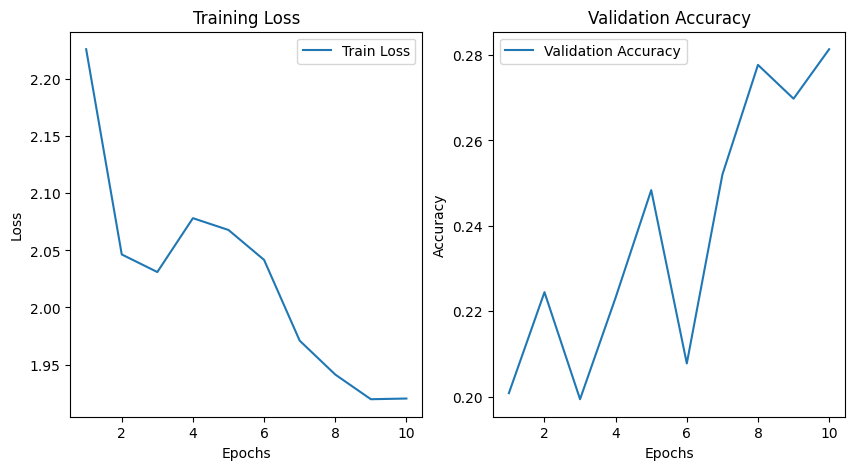


Testing
Test Accuracy: 0.2920


In [5]:
vit_model = ViT()

print(f"\nTraining")
model = vit_model.to(device)
train_losses, val_accuracies = train_model(model, train_loader, val_loader, num_epochs=10)
plot_metrics(train_losses, val_accuracies)
print(f"\nTesting")
test_model(model, test_loader)